In [2]:
import numpy as np 
import mne
import os
from scipy import signal
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import utils as np_utils
from sklearn.model_selection import train_test_split
from EEGModels import EEGNet, DeepConvNet
from htnet_model import htnet
import autokeras as ak

In [6]:
path=os.path.abspath(os.path.join(os.path.dirname(" __file__" ), '../..', 'bci3_npz'))
data=np.load(path+"/"+"bci_3.npz")
X=data['X']
events_ts=data['events'].squeeze()
event_id=dict(finger=-1, tongue=1)
n_channels=X.shape[1]
s_freq=1000

In [7]:
info=mne.create_info(n_channels,sfreq=s_freq)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 64 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 1000.0 Hz
>


In [8]:
events_ts_segmented=np.empty((events_ts.shape[0]*3),dtype=int)
j=0
for i in range(events_ts.shape[0]):
    events_ts_segmented[j]=events_ts[i]
    events_ts_segmented[j+1]=events_ts[i]
    events_ts_segmented[j+2]=events_ts[i]
    j=j+3

In [9]:
len=events_ts_segmented.shape[0]
ev=[i*s_freq*1 for i in range(len)]

In [10]:
events=np.column_stack((np.array(ev),np.zeros(len, dtype=int),np.array(events_ts_segmented)))
events

array([[     0,      0,     -1],
       [  1000,      0,     -1],
       [  2000,      0,     -1],
       ...,
       [831000,      0,     -1],
       [832000,      0,     -1],
       [833000,      0,     -1]])

In [11]:
j=0
X_segmented=np.empty((X.shape[0]*3,64,1000))
for i in range(X.shape[0]):
    X_segmented[j,:,:]=X[i,:,:1000]
    X_segmented[j+1,:,:]=X[i,:,1000:2000]
    X_segmented[j+2,:,:]=X[i,:,2000:3000]
    j=j+3

In [12]:
X_segmented.shape, events.shape


((834, 64, 1000), (834, 3))

In [13]:
tmin=0
epochs=mne.EpochsArray(X_segmented,info,events,tmin,event_id)

In [14]:
X=epochs.get_data()
y=epochs.events[:, -1]

In [15]:
test_data=data['X_test']
true_labels=np.loadtxt('true_labels_bci3.txt')

In [16]:
j=0
test_segmented=np.empty((test_data.shape[0]*3,64,1000))
for i in range(test_data.shape[0]):
    test_segmented[j,:,:]=test_data[i,:,:1000]
    test_segmented[j+1,:,:]=test_data[i,:,1000:2000]
    test_segmented[j+2,:,:]=test_data[i,:,2000:3000]
    j=j+3

In [17]:
true_labels_segmented=np.empty((true_labels.shape[0]*3),dtype=int)
j=0
for i in range(true_labels.shape[0]):
    true_labels_segmented[j]=true_labels[i]
    true_labels_segmented[j+1]=true_labels[i]
    true_labels_segmented[j+2]=true_labels[i]
    j=j+3

In [18]:
np.savez_compressed("bci3epochs.npz",X=X,y=y,X_test=test_segmented,y_test=true_labels_segmented)

In [19]:
X.shape, y.shape

((834, 64, 1000), (834,))

In [238]:
# X_train      = X[0:139,]
# Y_train      = y[0:139]
# X_validate   = X[139:208,]
# Y_validate   = y[139:208]
# X_test       = X[208:,]
# Y_test       = y[208:]

X_train, X_validate, Y_train, Y_validate=train_test_split(X,y,test_size=0.2,random_state=42)

In [239]:
kernels, chans, samples = 1, 64, 250

Y_train      = np_utils.to_categorical((Y_train+1)/2)
Y_validate   = np_utils.to_categorical((Y_validate+1)/2)

# convert data to NHWC (trials, channels, samples, kernels) format.
X_train      = X_train.reshape(X_train.shape[0], chans, samples,kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)

In [240]:
print(Y_train.sum(axis=0),Y_validate.sum(axis=0))

[336. 331.] [81. 86.]


In [241]:
initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

In [242]:
# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples, dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')
# model= DeepConvNet(nb_classes=2, Chans = chans, Samples = samples,dropoutRate = 0.3)
# model = htnet(nb_classes = 2, Chans = chans, Samples = samples, dropoutRate = 0.5, kernLength = 64, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')


# compile the model and set the optimizers
optimizer = tf.keras.optimizers.Adam(lr=0.005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath='checkpoint.h5', verbose=1,save_best_only=True)


fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 100, verbose = 2, validation_data=(X_validate, Y_validate),callbacks=[checkpointer])

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.61209, saving model to checkpoint.h5
42/42 - 5s - loss: 0.6546 - accuracy: 0.6042 - val_loss: 0.6121 - val_accuracy: 0.6048
Epoch 2/100

Epoch 00002: val_loss improved from 0.61209 to 0.61194, saving model to checkpoint.h5
42/42 - 5s - loss: 0.5232 - accuracy: 0.7391 - val_loss: 0.6119 - val_accuracy: 0.6707
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.61194
42/42 - 5s - loss: 0.4905 - accuracy: 0.7646 - val_loss: 0.6440 - val_accuracy: 0.6587
Epoch 4/100

Epoch 00004: val_loss improved from 0.61194 to 0.54282, saving model to checkpoint.h5
42/42 - 5s - loss: 0.5111 - accuracy: 0.7376 - val_loss: 0.5428 - val_accuracy: 0.6467
Epoch 5/100

Epoch 00005: val_loss improved from 0.54282 to 0.50460, saving model to checkpoint.h5
42/42 - 5s - loss: 0.4626 - accuracy: 0.7886 - val_loss: 0.5046 - val_accuracy: 0.7246
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.50460
42/42 - 5s - loss: 0.4452 - accuracy: 0.7796 

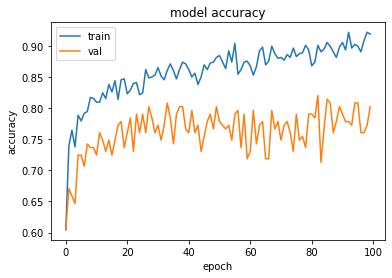

In [243]:
plt.figure(0)
plt.plot(fittedModel.history['accuracy'])
plt.plot(fittedModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

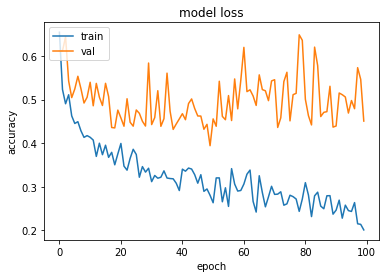

In [244]:
plt.figure(1)
plt.plot(fittedModel.history['loss'])
plt.plot(fittedModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# model.load_weights('checkpoint.h5')
# probs       = model.predict(X_test)
# preds       = probs.argmax(axis = -1)  
# acc         = np.mean(preds == Y_test.argmax(axis=-1))
# print("Classification accuracy: %f " % (acc))

In [245]:
model.load_weights('checkpoint.h5')
test_data=data['X_test']
true_labels=np.loadtxt('true_labels_bci3.txt')
print(test_data.shape,true_labels.shape)

(100, 64, 3000) (100,)


In [246]:
j=0
test_segmented=np.empty((test_data.shape[0]*3,64,1000))
for i in range(test_data.shape[0]):
    test_segmented[j,:,:]=test_data[i,:,:1000]
    test_segmented[j+1,:,:]=test_data[i,:,1000:2000]
    test_segmented[j+2,:,:]=test_data[i,:,2000:3000]
    j=j+3

In [247]:
true_labels_segmented=np.empty((true_labels.shape[0]*3),dtype=int)
j=0
for i in range(true_labels.shape[0]):
    true_labels_segmented[j]=true_labels[i]
    true_labels_segmented[j+1]=true_labels[i]
    true_labels_segmented[j+2]=true_labels[i]
    j=j+3

In [248]:
test_segmented.shape, true_labels_segmented.shape

((300, 64, 1000), (300,))

In [249]:
new_test_data=np.empty([300,64,250])
for i in range(0,300):
    for j in range(0,64):
        array=test_segmented[i,j,:]
        array=array.astype('float64')
        new_test_data[i,j,:]=signal.resample(array,250)
new_test_data= new_test_data.reshape(new_test_data.shape[0], chans, samples, kernels)
true_labels_segmented= np_utils.to_categorical((true_labels_segmented+1)/2)


In [250]:
new_test_data.shape, true_labels_segmented.shape

((300, 64, 250, 1), (300, 2))

In [251]:
probs_test=model.predict(new_test_data)
preds_test=probs_test.argmax(axis=-1)
acc_test=np.mean(preds_test==true_labels_segmented.argmax(axis=-1))
print("Test Accuracy: %f"% (acc_test))


Test Accuracy: 0.500000
